# Visualizing air quality and imagery resulting from the Thomas Fire in December 2017

### Charlie Curtin

Github repository: https://github.com/charliecurtin1/air_quality_and_imagery

## About

#### Purpose

The Thomas Fire occurred in Santa Barbara County in December 2017, covering an area of around 280,000 acres. Wildfires are a natural feature on our landscape and carry many positive benefits, including nutrient cycling and sprouting of fire-dependent vegetation. When they become too severe, burning a large area or burning too intensely, they can carry negative effects, like enabling devastating landslides through the loss of vegetation. Besides their immediate threat to people, wildfires are also a health risk through the emission of particulate matter.

#### Highlights of analysis

This analysis will visualize the burn scar of the Thomas Fire using Landsat imagery and false color band combinations. We will show techniques to modify and visualize raster data, as well as plotting raster and vector data together. We will also visualize the daily AQI index, a measure of air quality, for Santa Barbara County during a window of time that includes the Thomas Fire. This part of the analysis will show techniques to clean dataframes, join data together, and work with time series data to calculate a moving average.

#### Datasets

**Landsat 8**

The Landsat data was processed and downloaded from the Microsoft Planetary Computer. The area of interest is cropped to show Santa Barbara County. The data is stored as an `xarray.Dataset`. It includes 5 data variables, which represent the 5 color bands available for visualization.

- Link: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

**California Fire Perimeters**

This dataset shows fire perimeters, including wildfires and prescribed burns, for the State of California. The data was created by the California Department of Forestry and Fire Protection (CalFire) and is hosted on the California State Geoportal. It includes information like the year of the fire, the fire footprint, and the area burned.

- Link: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

**Air Quality Index**

This dataset was created by the US Environmental Protection Agency and describes daily air quality index values by county in the United States. Data are available as .csv files by year from 1980-2022. For our analysis, we used data from 2017 and 2018.

- Link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

### Import libraries and functions

In [1]:
# import libraries and functions
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.lines as mlines
from shapely.geometry import box

### Import and prepare our imagery and fire perimeter data

To visualize the Thomas Fire burn scar, we will use the California Fire Perimeters and Landsat imagery.

In [2]:
# read in the CA fire perimeters and landsat data
ca_fire = gpd.read_file(os.path.join(os.getcwd(), 'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp'))

landsat = rioxr.open_rasterio(os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc'))

Next we need to prepare our data for visualization. Since our `xarray.Dataset` needs to be two-dimensional to plot, we'll drop the single band and it's coordinates from our dimensions. We'll also select just the Thomas Fire from our fire perimeters and make sure our two datasets are in the same coordinate reference system.

In [4]:
# drop the band dimension and its coordinates from the landsat raster because there is only one band
landsat = landsat.squeeze()
landsat = landsat.drop('band')

# select the thomas fire perimeter
thomas_fire = ca_fire[ca_fire.FIRE_NAME == 'THOMAS']

# set the layers on a common CRS
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

### Visualizing the Thomas Fire burn scar

We can display the burn scar of the Thomas Fire by using false color imagery. We'll plot the band combination of shortwave infrared, near infrared, and red. Newly-burned land reflects short wave infrared intensely, so the false color imagery should display the burn scar in bright red. We'll also plot the perimeter of the Thomas Fire on top of the imagery to verify.

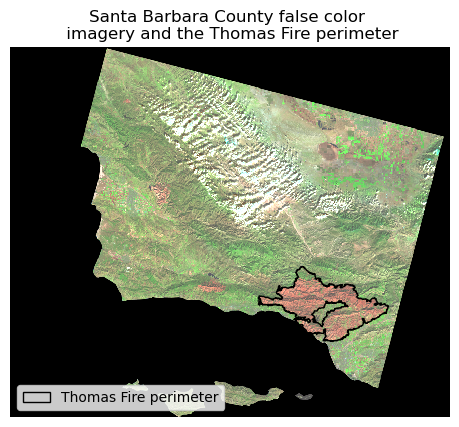

In [5]:
## map the Thomas Fire perimeter on top of a false color image of Santa Barbara County
# initialize the map and turn the lat/long ticks off
fig, ax = plt.subplots()
ax.axis('off')

# plot the false color image with bands shortwave IR, near IR, and red
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

# plot the Thomas Fire perimeter
thomas_fire.plot(ax = ax,
                color = 'none',
                edgecolor = 'black')
# create a graphical patch for the legend
thomas_fire_patch = mpatches.Rectangle((0, 0), 0, 0,
                                        facecolor = 'none',
                                        edgecolor = 'black',
                                        label = 'Thomas Fire perimeter')

# create a legend
ax.legend(handles = [thomas_fire_patch],
         loc = 'lower left')

# set map title
plt.title("Santa Barbara County false color \n imagery and the Thomas Fire perimeter")

# show the plot without the output text
_ = plt.show()

### Import and prepare our air quality index data

Next we'll read in our daily AQI data for 2017 and 2018.

In [6]:
# read in the 2017 AQI data 
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")

# read in the 2018 AQI data
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

Next we'll concatenate the dataframes into one, clean up column names, and subset data for Santa Barbara County

In [ ]:
# concatenate the 2017 and 2018 dataframes to create a new dataframe
aqi = pd.concat([aqi_17, aqi_18])

# clean up the column names in our dataframe by changing them to snakecase
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# subset data from Santa Barbara County, remove the columns 'state_name', 'county_name', 'state_code', and 'county_code' to create a new dataframe
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara'].drop(['state_name', 'county_name', 'state_code', 'county_code'], axis = 1)

To prepare our data for plotting, we'll need to turn the date column into a datetime object. This will allow us to work with the time series properly and calculate the 5 day rolling average of AQI over the 2 year period in Santa Barbara.

In [11]:
# update the date column of aqi_sb to be a datetime object
aqi_sb.date = pd.to_datetime(aqi_sb.date)

# update the index of aqi_sb to be the date column
aqi_sb = aqi_sb.set_index('date')

# add the mean 5 day rolling average of AQI to the aqi_sb dataframe as a new column
aqi_sb = aqi_sb.assign(five_day_average = aqi_sb.aqi.rolling('5D').mean())

Now we can plot our daily and 5 day rolling average of AQI in Santa Barbara County.

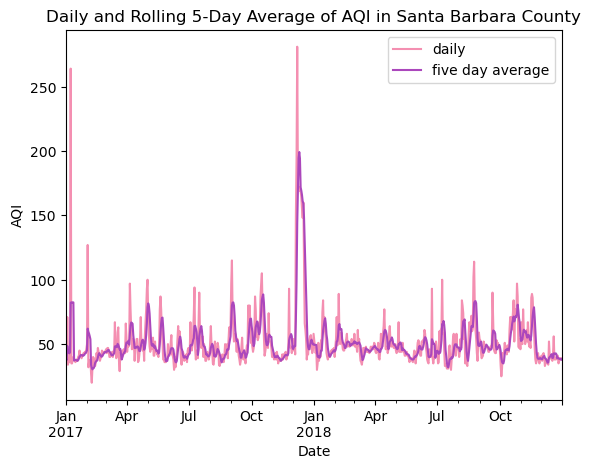

In [12]:
# initialize plot
fig, ax = plt.subplots()

# plot daily and five day average aqi
_ = aqi_sb[['aqi', 'five_day_average']].plot(ax = ax,
                                            title = 'Daily and Rolling 5-Day Average of AQI in Santa Barbara County',
                                            xlabel = 'Date',
                                            ylabel = 'AQI',
                                            color = {'aqi':'#F48FB1', 'five_day_average':'#AB47BC'})

# change legend labels
_ = ax.legend(labels = ("daily", "five day average"))

### Discussion

As we can see from the final plot, there was a large spike in AQI during December 2017 in both the daily and five day average. Our daily values spiked during this time between 250 and 300, which is classified as "very unhealthy" in the AQI Index. The five day average during this period spiked above 200, which would also be classified as "very unhealthy".